# __Scenario B:__<br>α-glucosidase inhibition by fucoidan

Data provided by Chantal Daub (Biochemistry, Rhodes University, Makhanda, South Africa)

## Project background
In this scenario, the inhibitory properties of fucoidan on $\alpha$-glucosidase from *Saccharomyces cerevisiae* were analyzed. Fucoidan is a sulfated polysaccharide found in various brown algae. The polysaccharide is investigated as a potential active compound in the fields of anti-cancer, anti-inflammation, and anti-coagulate research, among others {cite}`li2008fucoidan`. Furthermore, fucoidan showed to be a promising drug for diabetes mellitus treatment, since it effectively inhibits $\alpha$-glucosidase. Recently, {cite:t}`daub2020fucoidan` showed that $\alpha$-glucosidase inhibition by fucoidan from *E. maxima* exhibited significantly stronger inhibition, compared to the established diabetes drug acarbose.  
In the following analysis, $\alpha$-glucosidase was exposed to fucoidan from *Ecklonia maxima*, *Ecklonia radiata*, *Fucus vesiculosus*, and *Schimmelmannia elegans* to test their respective capability of $\alpha$-glucosidase inhibiton by assessing their respective $K_{i}$ values.

### Experimental design 
$\alpha$-glucosidase reactions, catalyzing the hydrolysis of p-nitrophenyl glucopyranoside (p-NPG) to p-nitrophenol (p-NP) were conducted with and without fucoidan from each seaweed species as well as acarbose. Fucoidan was applied in two different concentrations. p-NPG was applied in a range from 0.1 mM - 5 mM, to enzyme reactions containing 9.19 µM $\alpha$-glucosidase.
Product formation was recorded photometrically at 405 nm and 37°C for 20 min. Product concentrations were calculated utilizing a photometric p-NP standard. Additionally, control reactions without enzyme were prepared to subtract the absorption contribution of the respective inhibitor, buffer, enzyme and substrate from each measurement.

## Data preparation

### Imports and parser function

In [1]:
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
import os
import pyenzyme as pe
from IPython.display import display
from CaliPytion.tools.standardcurve import StandardCurve
from EnzymePynetics.tools.parameterestimator import ParameterEstimator


import warnings
warnings.filterwarnings('ignore')

colors = list(mcolors.TABLEAU_COLORS.values())

# Parser
def measurement_data_to_EnzymeML(
    template_path: str,
    measurement_data: np.ndarray,
    species_id: str,
    time: np.ndarray,
    data_unit: str,
    time_unit: str
    ) -> pe.EnzymeMLDocument:

    enzmldoc: pe.EnzymeMLDocument = pe.EnzymeMLDocument.fromTemplate(template_path)

    for IDs, concentration in zip(enzmldoc.measurement_dict.keys(), measurement_data):
        for counter, replicate in enumerate(concentration):
            
            enzmldoc.getMeasurement(IDs).addReplicates(pe.Replicate(
                id=f"Measurement{counter}",
                species_id=species_id,
                data=list(replicate),
                data_unit=data_unit,
                time=list(time),
                time_unit=time_unit), enzmldoc)

    return enzmldoc

# Ignore hidden files in file stystem
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

Measurement data was provided as an Excel file, whereas metadata was filled in EnzymeML Excel templates for each fucoidan seaweed species and acarbose respectively. In preliminary experiments, p-NPG showed to slightly absorb at the product detection wavelength. Therefore, the absorbance contribution of substrate at the product detection wavelength was subtracted as well as the contributions of enzyme, buffer and inhibitor. Then, the blanked absorbance data was written to the EnzymeML documents by a parser function.

In [2]:
dataset_path = "../../data/glucosidase_inhibition/experimental_data_real.xlsx"
template_directory = "../../data/glucosidase_inhibition/EnzymeML_templates"   

enzml_docs = []
# Load experimental data from Excel
excel_sheets = sorted(pd.ExcelFile(dataset_path).sheet_names)
inhibitors = excel_sheets[:-1]
substrate_controls = excel_sheets[-1]
initial_substrates = [0.1, 0.25, 0.5, 1, 2.5, 5] # mM

# Blank data
## Absorption contribution from substrate
substrate_absorption_data = pd.read_excel(dataset_path, sheet_name=substrate_controls).set_index("time")
buffer_enzyme_absorption = np.mean(substrate_absorption_data.iloc[:,0])
substrate_absorptions = substrate_absorption_data.subtract(buffer_enzyme_absorption).drop(columns=["Buffer+ Enzyme"])
substrate_absorptions = substrate_absorptions.values.T.reshape(2,6,21)
substrate_absorptions = np.mean(substrate_absorptions, axis=0)
substrate_absorptions = np.mean(substrate_absorptions, axis=1)
mapper_substrate_enzyme_absorption = dict(zip(initial_substrates, substrate_absorptions))

for inhibitor, template in zip(sorted(inhibitors), sorted(listdir_nohidden(template_directory))):
    df = pd.read_excel(dataset_path, sheet_name=inhibitor).set_index("time")
    time = df.index.values
    inhibitor_controls = df.iloc[:,:4]
    inhibitor_concs = np.unique([float(conc.split(" ")[-2]) for conc in inhibitor_controls.columns])
    inhibitor_absorptions = inhibitor_controls.values.T.reshape(2,2,21)
    inhibitor_absorptions = np.mean(inhibitor_absorptions, axis=1)
    inhibitor_absorptions = np.mean(inhibitor_absorptions, axis=1)
    mapper_inhibitor_absorption = dict(zip(inhibitor_concs, inhibitor_absorptions))
    mapper_inhibitor_absorption[0.0] = buffer_enzyme_absorption
    df = df.iloc[:,4:]
    for column in df.columns:
        init_substrate = float(column.split(" ")[4])
        inhibitor_conc = float(column.split(" ")[1])
        df[column] = df[column] - mapper_substrate_enzyme_absorption[init_substrate] 
        df[column] = df[column] - mapper_inhibitor_absorption[inhibitor_conc]
    
    data = df.values.T.reshape(3,2,6,21)
    data = np.moveaxis(data,1,2).reshape(18,2,21)

    # Parse measurement data to EnzymeML documents
    enzml_docs.append(measurement_data_to_EnzymeML(
        template_path=f"{template_directory}/{template}",
        measurement_data=data,
        time=time,
        species_id="s1",
        data_unit="mmole / l",
        time_unit="min"
    ))

### Data quality

In the next cell, the blanked absorption data of each EnzymeML document is visualized with the ```.visualize()```-method of ```PyEnzyme``` for quality control.

a-glucosidase inhibition by acarbose


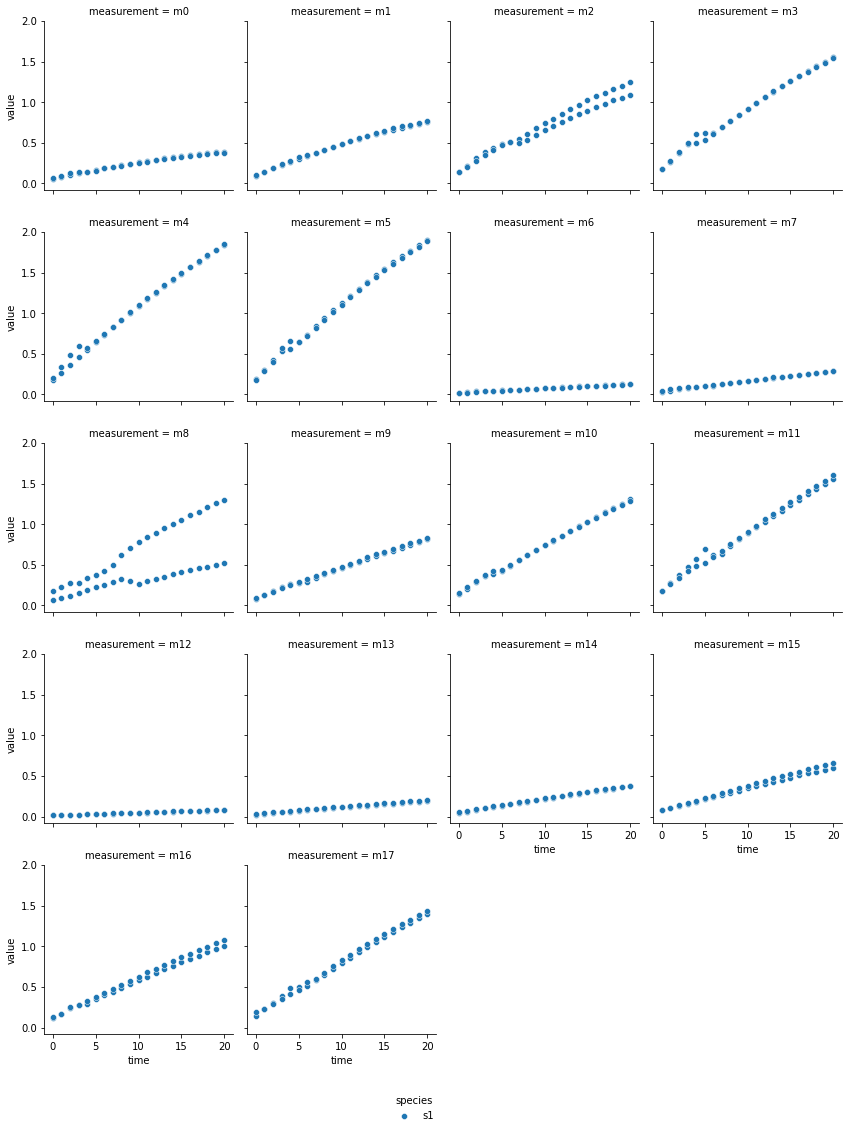

a-glucosidase inhibition by fucoidan from E. maxima


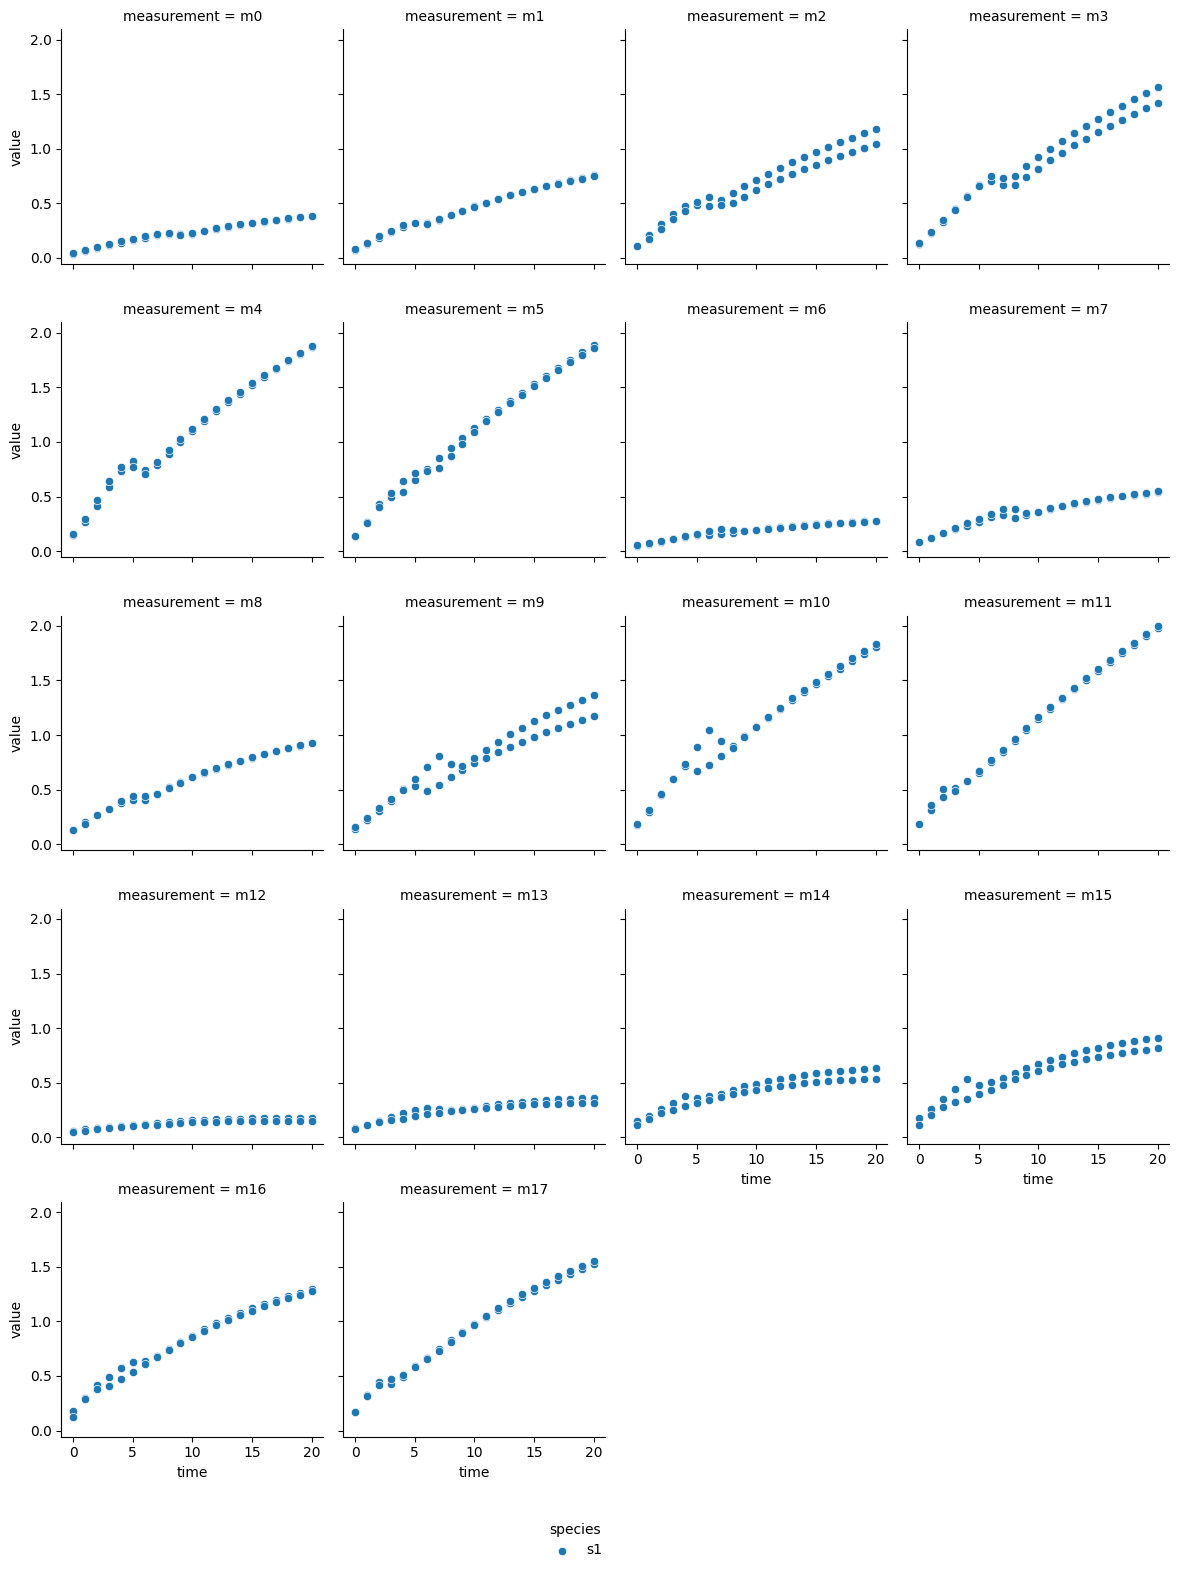

a-glucosidase inhibition by fucoidan from E. radiata


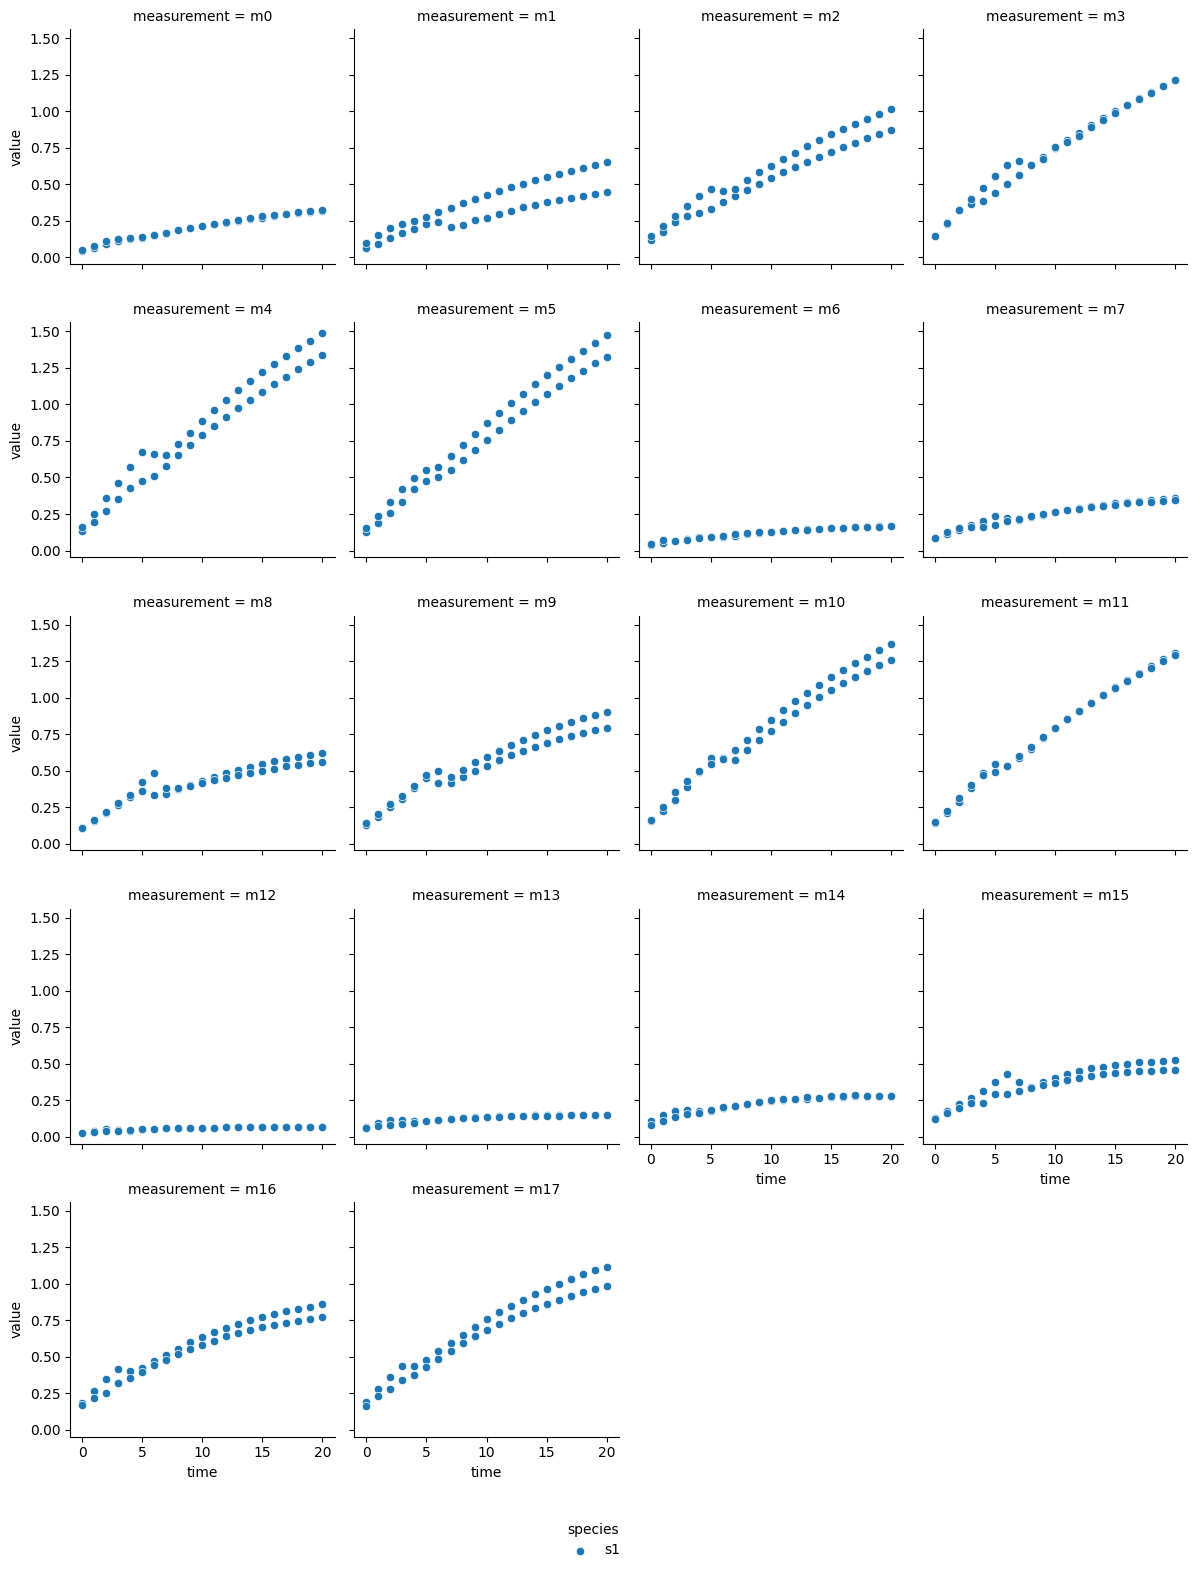

a-glucosidase inhibition by fucoidan from F. vesiculosus


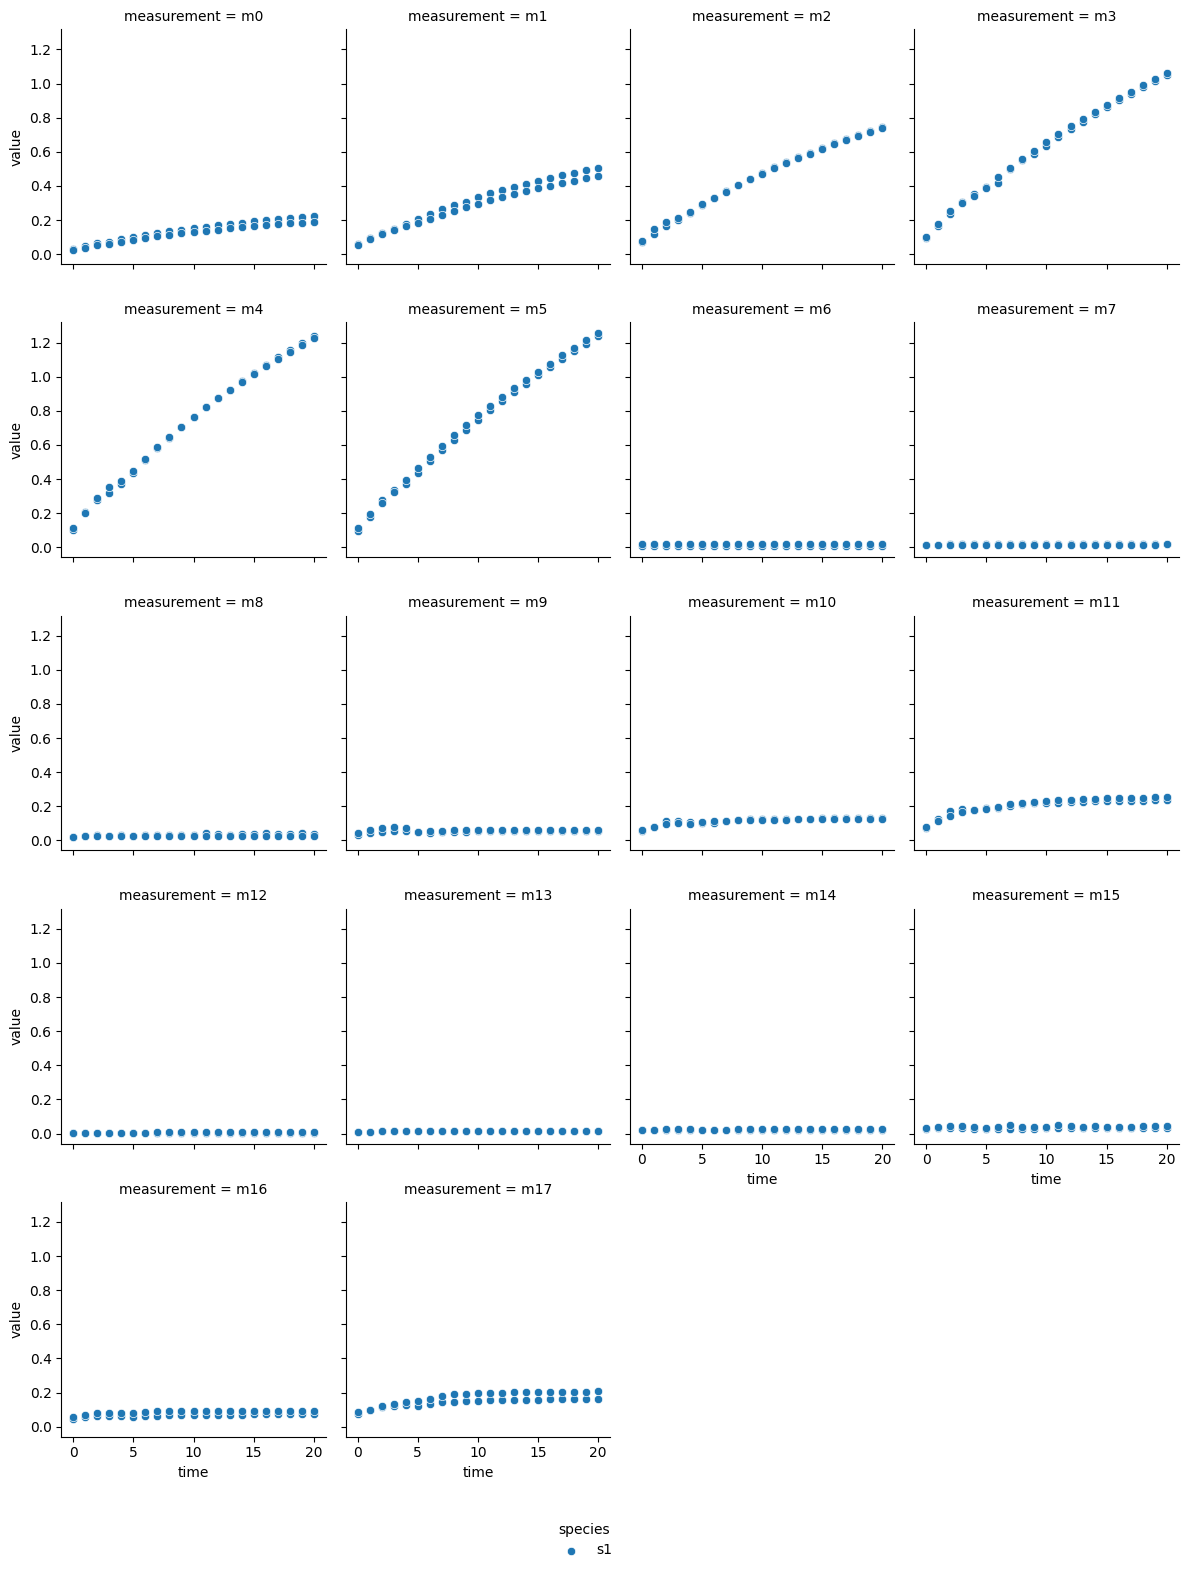

a-glucosidase inhibition by fucoidan from S. elegans


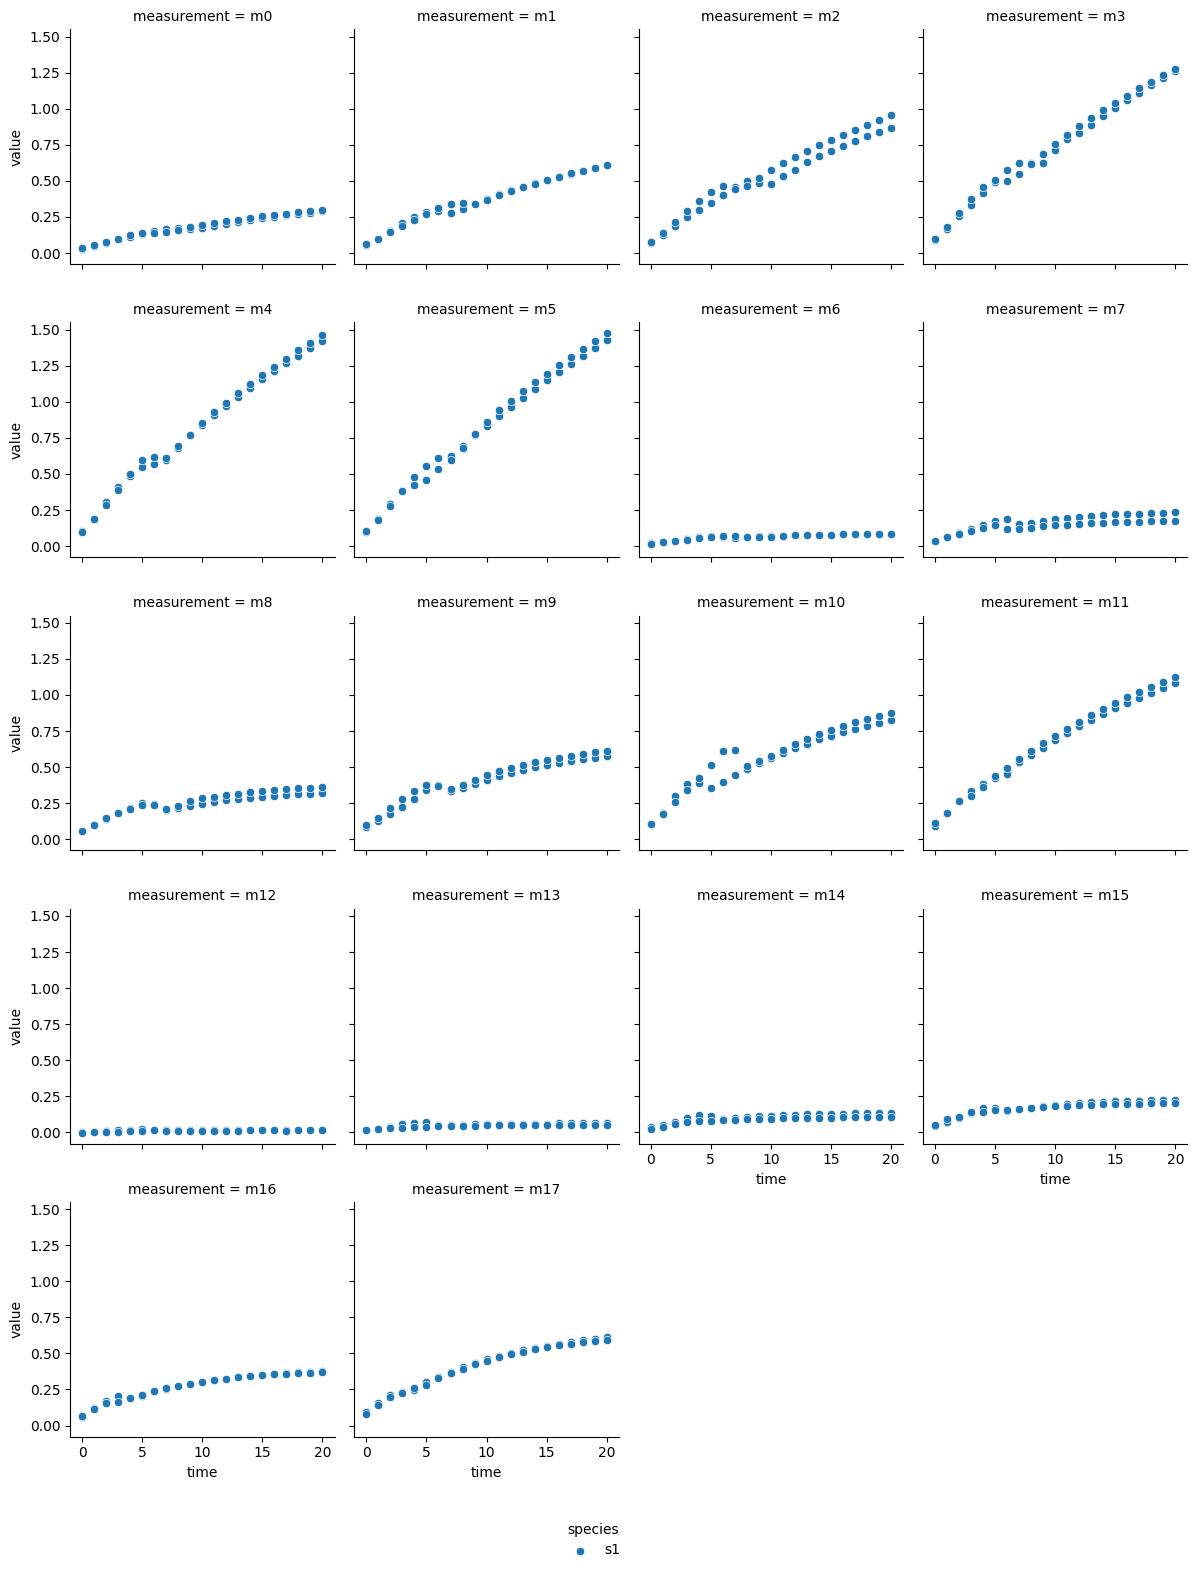

In [3]:
for doc in enzml_docs:
    print(doc.name)
    doc.visualize()
    plt.show()

The technical output of the cell above visualizes the blanked product absorbance data of each dataset. Therein, the individual measurements are labeled from m0 - m17, which represent individual experimental conditions: measurements m0 - m5 are from reactions without inhibitor, m6 - m11 reactions with the lower inhibitor concentration, and m12 - m17 originate from reactions with the higher inhibitor concentration. Each subplot contains the data of two experimental repeats.  
In most reactions a decrease followed by an increase of reaction rate is visible around minute 5. Since each dataset originates from a continuous photometric measurement carried out on a single MTP, the observed behavior likely sources from an analytical device malfunction. Additionally, one repeat of measurement 'm8' from the acarbose dataset shows low absorption, which is inconsistent with comparable measurements. Therefore, 'm8' was excluded from the dataset.

In [4]:
del enzml_docs[0].measurement_dict["m8"].getReactant("s1").replicates[0]


### Concentration calculation

Standard data of p-NP was loaded from an Excel file, and a standard curve was created. Then, the standard curve was applied to the EnzymeML documents.

Calibration data was automatically blanked.


,AIC
3rd polynominal,-135
Quadratic,-135
Rational,-135
Linear,-125
Exponential,-11


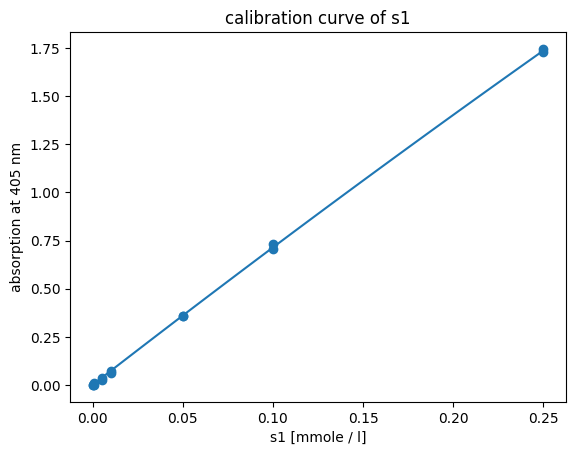

In [5]:
path_calibration_data = "../../data/glucosidase_inhibition/p-NP_standard.xlsx"

product_standard = StandardCurve.from_excel(
    path=path_calibration_data,
    reactant_id="s1", 
    sheet_name="csv", 
    wavelength=405, 
    concentration_unit = "mmole / l", 
    cutoff_absorption=2)

product_standard.visualize("Quadratic")

# Apply calibration curves to absorption EnzymeML documents
for enzmldoc in enzml_docs:
    product_standard.apply_to_EnzymeML(enzmldoc, "s1", "Quadratic")

_Fig. 5: Fitted quadratic calibration model to standard data of p-NP (s1)._

Based on AIC, 3<sup>rd</sup>-degree polynomial, quadratic and rational calibration models describe the relation between absorption to concentration ration of p-NP equally. Since the 3<sup>rd</sup>-degree polynomial model has one additional parameter compared to the quadratic model, the calibration model with less parameters is preferred, since the additional parameter did not give additional information. The fit between quadratic calibration model and calibration standard is visualized in Fig. 5.

## Parameter estimation

Comparison between different inhibition models and thus determining the kinetic mechanism was not possible, as no model was consistently favored over the other based on AIC and standard deviations of the parameter estimates. 


Thus, different inhibition models cannot be compared, since information provided by the initial slopes is insufficient to distinguish kinetic inhibition mechanisms by modeling. In consequence, kinetic parameters were estimated based on initial rates, assuming competitive inhibition, since this kinetic mechanism has been proposed {cite}`shan2016vitro`.  
Additionally, the faulty measurement with an initial substrate concentration of 0.5 mM from the acarbose data set was excluded from parameter estimation. 
Based on an initial parameter estimation run with subsequent visual analysis, severals measurements from the *E. maxima* dataset were excluded. Thereby, measurements from both applied inhibitor concentrations and an initial substrate concentration of 2.5 mM and 5 mM showed similar activity compared to reactions without inhibitor. In contrast, the reactions with inhibitor present showed inhibition, according to the difference in slope.

In [6]:
# Discard measurement with 2.5 mM and 5 mM and lower inhibition concentration from E. maxima dataset
del enzml_docs[1].measurement_dict["m10"]
del enzml_docs[1].measurement_dict["m11"]
del enzml_docs[1].measurement_dict["m16"]
del enzml_docs[1].measurement_dict["m17"]


In [7]:
# Run parameter estimation for all data sets
results=[]
for enzmldoc in enzml_docs:
    result = ParameterEstimator.from_EnzymeML(enzmldoc=enzmldoc, reactant_id="s1", inhibitor_id="s2", measured_species="product")
    result.fit_models(enzyme_inactivation=False, display_output=False, stop_time_index=3)
    results.append(result)

# Display results for competitive inhibition model
labels = np.array(["Acarbose", "Fucoidan (E. maxima)", "Fucoidan (E. radiata)", "Fucoidan (F. vesiculosus)", "Fucoidan (S. elegans)"])
df = pd.concat([result.result_dict.loc["competitive inhibition"].to_frame().T for result in results],\
    keys=labels)\
        .reset_index()\
        .drop(columns=["level_1", "AIC", "Ki uncompetitive [g / l]"])\
        .set_index("level_0")\
        .rename_axis("Inhibitor", axis = 0)
print("Kinetic parameters based on competitive inhibition model:")
display(df.style.set_table_attributes('style="font-size: 12px"'))


Kinetic parameters based on competitive inhibition model:


,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l]
Inhibitor,,,,
Acarbose,1.903 +/- 2.77%,0.341 +/- 10.79%,5.581 +/- 11.14%,0.112 +/- 10.80%
Fucoidan (E. maxima),2.317 +/- 2.14%,0.406 +/- 7.64%,5.701 +/- 7.93%,0.874 +/- 14.25%
Fucoidan (E. radiata),1.343 +/- 2.75%,0.180 +/- 14.57%,7.461 +/- 14.83%,0.028 +/- 19.29%
Fucoidan (F. vesiculosus),1.467 +/- 2.07%,0.415 +/- 7.37%,3.531 +/- 7.66%,0.003 +/- 7.80%
Fucoidan (S. elegans),1.474 +/- 2.42%,0.251 +/- 10.79%,5.863 +/- 11.06%,0.016 +/- 11.88%


The output above displays estimated kinetic parameters for all data sets, assuming competitive inhibition between enzyme and inhibitor. As a result $k_{cat}$ was estimated between 2.317 min<sup>-1</sup> ± 2.14% and 1.343 min<sup>-1</sup> ± 2.75%, whereas $K_{m}$ was estimated between 0.415 mM ± 7.37% and 0.180 mM ± 14.57%. 
Since all measurements were conducted under equal conditions, $k_{cat}$ and $K_{m}$ should be similar across experiments. Deviations in parameter values might therefore result from pipetting or deviations in reaction temperature.

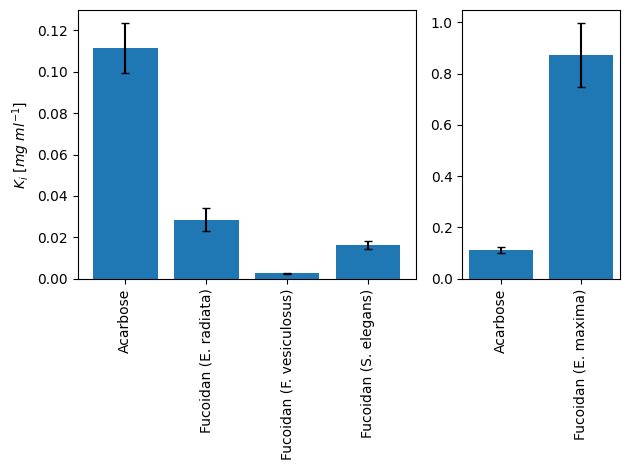

In [8]:
# Get K_i parameter results
def get_parameter(result, model_name: str, parameter: str):
    return result.models[model_name].result.params[parameter]

ki = []
ki_stderr = []
for result in results:
    ki.append(get_parameter(result, "competitive inhibition", "K_ic").value)
    ki_stderr.append(get_parameter(result, "competitive inhibition", "K_ic").stderr)
ki = np.array(ki)
ki_stderr = np.array(ki_stderr)

# Visualize
kis = dict(zip(labels,ki))
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3,1.4]})
a0.bar(labels[[0,2,3,4]], ki[[0,2,3,4]], yerr=ki_stderr[[0,2,3,4]], align='center', capsize=3)
a0.set_xticklabels(labels[[0,2,3,4]], rotation = 90)
a1.bar(labels[:2], ki[:2], yerr=ki_stderr[:2], align='center', capsize=3)
a1.set_xticklabels(labels[:2], rotation = 90)
a0.set_ylabel("$K_{i}$ [$mg$ $ml^{-1}$]")
plt.tight_layout()

_Fig. 6: Estimated inhibitory constants for $\alpha$-glucosidase inhibition by fucoidan from different algae species and acarbose_

Fucoidan from *E. radiata*, *F. vesiculosus*, and *S. elegans* all showed a lower $K_{i}$ (28, 3, and 16 µg ml<sup>-1</sup>, respectively) compared to the acarbose reference (112 µg ml<sup>-1</sup>). This resembles a 37-fold higher binding affinity of fucoidan from *F. vesiculosus* to $\alpha$-glucosidase compared to acarbose. In contrast to the previous study, fucoidan from *E. maxima* showed a more than 7-fold higher $K_{i}$ (858 µg ml<sup>-1</sup>) compared to acarbose. This likely originates from inconsistencies during experimental preparation. Additionally, 4 of 10 measurements with applied inhibitor were excluded from parameter estimation, since they showed higher activity compared to the respective reactions without inhibitor. Therefore, these measurement should be repeated. Estimated inhibition constants for each tested inhibitor are visualized in Fig. 6.

## Project discussion

In general, the estimated parameters are not reliable on a quantitative level, since the malfunction of the analytical device undermines the validity of the whole dataset. Therefore, it cannot be ruled out, that some of the calculated concentrations deviate from the real concentrations. Furthermore, all estimated parameters are only estimated based on three time points of measure. In addition each experimental condition was applied as duplicate repeats, which additionally showed deviations.
In conclusion, the estimated parameters qualitatively confirm that fucoidan from different host organisms, inhibit $\alpha$-glucosidase more strongly, compared to acarbose.

## Save modeling results

Lastly, the modeling results are written to the EnzymeML documents and the files are exported.

In [9]:
for result, enzmldoc in zip(results, enzml_docs):

    # Write modeling results to kinetic parameters
    k_cat = pe.enzymeml.models.KineticParameter(
        name="k_cat",
        value=result.get_model_results()["k_cat"].value,
        unit=f"1 / {result.data.time_unit}")

    K_m = pe.enzymeml.models.KineticParameter(
        name="K_m",
        value=result.get_model_results()["Km"].value,
        unit=result.data.data_conc_unit)

    K_ic = pe.enzymeml.models.KineticParameter(
        name="K_ic",
        value=result.get_model_results()["K_ic"].value,
        unit=result.data.data_conc_unit)

    # Define kinetic model
    model = pe.KineticModel(
        name="competitive inhibition",
        equation="-k_cat * p0 * s0 / (K_m*(1+(s2 / K_ic))+s0)",
        parameters=[k_cat, K_m, K_ic])

    enzmldoc.getReaction("r0").model = model

    # Export EnzymeML documents
    export = False
    if export:
        enzmldoc.toFile()